In [86]:
# Importing Libs
import yfinance as yf  # For downloading stock data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For advanced visualization
from sklearn.linear_model import LinearRegression  # For the machine learning model
from sklearn.metrics import mean_absolute_error  # For model evaluation
from sklearn.impute import SimpleImputer, KNNImputer  # For handling missing values due to previous errors
from sklearn.ensemble import HistGradientBoostingRegressor  # Model that handles NaNs directly as previous test couldnt handle NaN values


In [87]:
# Fetching historical stock data for the past year (you can change the symbol for other stocks)
stock = yf.Ticker("BRK-B")  # Replace with any stock symbol you want to analyze
data = stock.history(period="1y")  # Get 1 year of historical data
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-30 00:00:00-04:00,470.519989,476.950012,470.000000,475.920013,7465800,0.0,0.0
2024-09-03 00:00:00-04:00,475.000000,482.890015,473.720001,476.829987,7511900,0.0,0.0
2024-09-04 00:00:00-04:00,478.679993,484.820007,474.220001,478.570007,5309400,0.0,0.0
2024-09-05 00:00:00-04:00,479.429993,479.429993,462.880005,464.920013,6213200,0.0,0.0
2024-09-06 00:00:00-04:00,463.820007,468.170013,458.549988,459.420013,4400300,0.0,0.0


In [88]:
print("Missing values in entire dataset:")
print(data.isnull().sum())

data.fillna(method='ffill', inplace=True)

# Calculate moving averages as additional features (50-day and 200-day moving averages)
data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average
data['MA200'] = data['Close'].rolling(window=200).mean()  # 200-day moving average

# Prepare features (X) and target variable (y)
X = data[['MA50', 'MA200']]
y = data['Close']

print("\nMissing values in features (X) after filling:")
print(X.isnull().sum())

print("\nMissing values in target (y) after filling:")
print(y.isnull().sum())

# If there are still NaNs, use KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
X = knn_imputer.fit_transform(X)
y = knn_imputer.fit_transform(y.values.reshape(-1, 1))  # Reshape y for imputation

# Ensure there are no NaN values after KNN imputation
print(f"\nMissing values in X after KNN imputation: \n{pd.DataFrame(X).isnull().sum()}")
print(f"Missing values in y after KNN imputation: \n{pd.DataFrame(y).isnull().sum()}")


Missing values in entire dataset:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Missing values in features (X) after filling:
MA50      49
MA200    199
dtype: int64

Missing values in target (y) after filling:
0

Missing values in X after KNN imputation: 
0    0
1    0
dtype: int64
Missing values in y after KNN imputation: 
0    0
dtype: int64


/tmp/ipython-input-3250791290.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


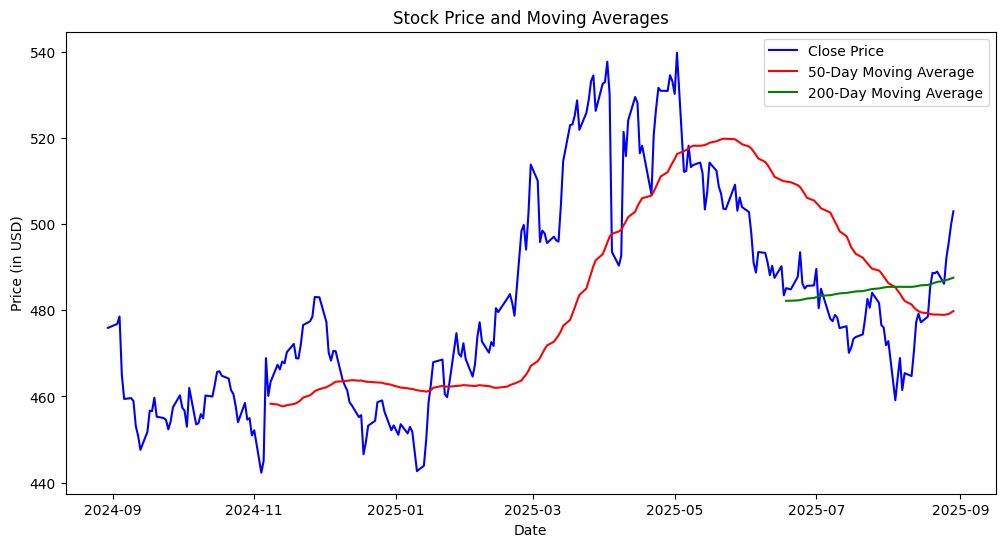

<Figure size 640x480 with 0 Axes>

In [98]:
# Plot the stock's closing price and the 50-day and 200-day moving averages
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA50'], label='50-Day Moving Average', color='red')
plt.plot(data['MA200'], label='200-Day Moving Average', color='green')
plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (in USD)')
plt.legend()
plt.show()
plt.savefig("prediction_plot.png", dpi=300, bbox_inches="tight")


In [90]:
# Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the data shapes after splitting
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (200, 2)
y_train shape: (200, 1)


/tmp/ipython-input-4064022997.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()  # Convert 2D array to 1D
/tmp/ipython-input-4064022997.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_pred = y_pred.ravel()  # Convert 2D array to 1D


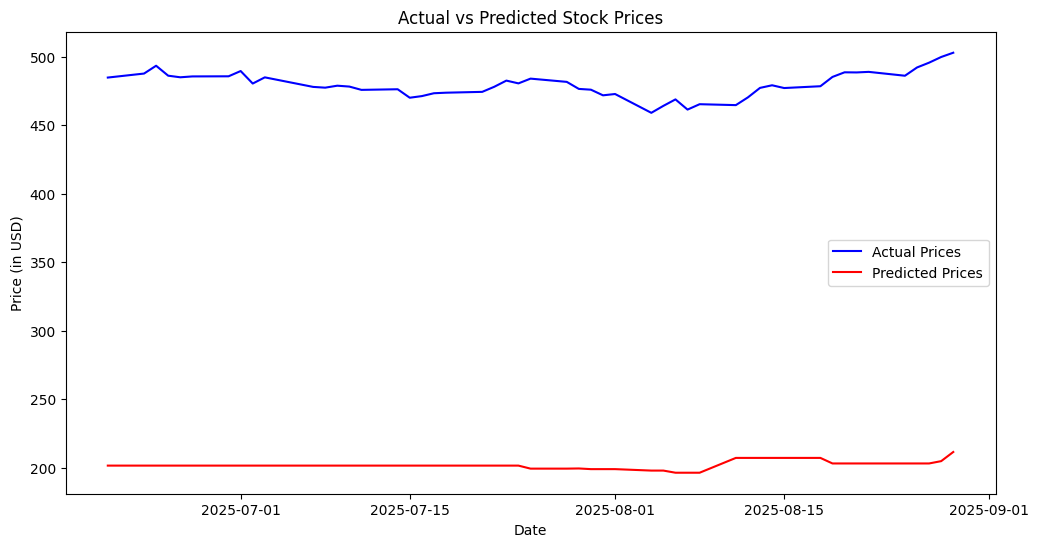

<Figure size 640x480 with 0 Axes>

In [99]:
# Flatten y_test and y_pred to 1D arrays
y_test = y_test.ravel()  # Convert 2D array to 1D
y_pred = y_pred.ravel()  # Convert 2D array to 1D

# Convert y_test to pandas Series to retain the index
y_test = pd.Series(y_test, index=data.index[-len(y_test):])

# Convert y_pred to pandas Series to retain the same index for plotting
y_pred = pd.Series(y_pred, index=data.index[-len(y_pred):])

# Plot the actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_pred.index, y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price (in USD)')
plt.legend()
plt.show()
plt.savefig("prediction_plot.png", dpi=300, bbox_inches="tight")


In [92]:
# Evaluate model performance using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate the MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R² score to measure how well the model fits the data
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')


Mean Absolute Error (MAE): 277.8212070648816
R-squared (R²): -888.5489186063503


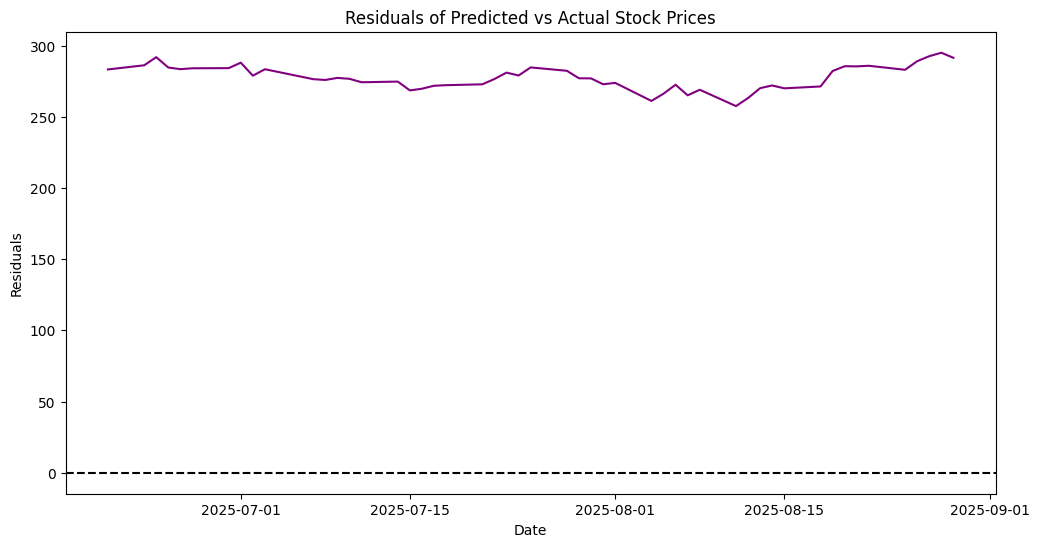

<Figure size 640x480 with 0 Axes>

In [100]:
# Calculate residuals (difference between actual and predicted values)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(12,6))
plt.plot(y_test.index, residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predicted vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()
plt.savefig("prediction_plot.png", dpi=300, bbox_inches="tight")


In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Hyperparameters for tuning LinearRegression inside the pipeline
param_grid = {
    'linearregression__fit_intercept': [True, False]  # Target LinearRegression's fit_intercept parameter
}

# Create a pipeline to scale the data and apply the linear regression model
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters from grid search
print(f'Best Parameters: {grid_search.best_params_}')


Best Parameters: {'linearregression__fit_intercept': True}


In [95]:
# Final model evaluation
y_pred_final = grid_search.predict(X_test)

# Evaluate model performance using Mean Absolute Error (MAE)
mae_final = mean_absolute_error(y_test, y_pred_final)
print(f'Mean Absolute Error (MAE) for Final Model: {mae_final}')

# Calculate R² score
r2_final = r2_score(y_test, y_pred_final)
print(f'R-squared (R²) for Final Model: {r2_final}')


Mean Absolute Error (MAE) for Final Model: 24.99728585440097
R-squared (R²) for Final Model: -8.40356802836519


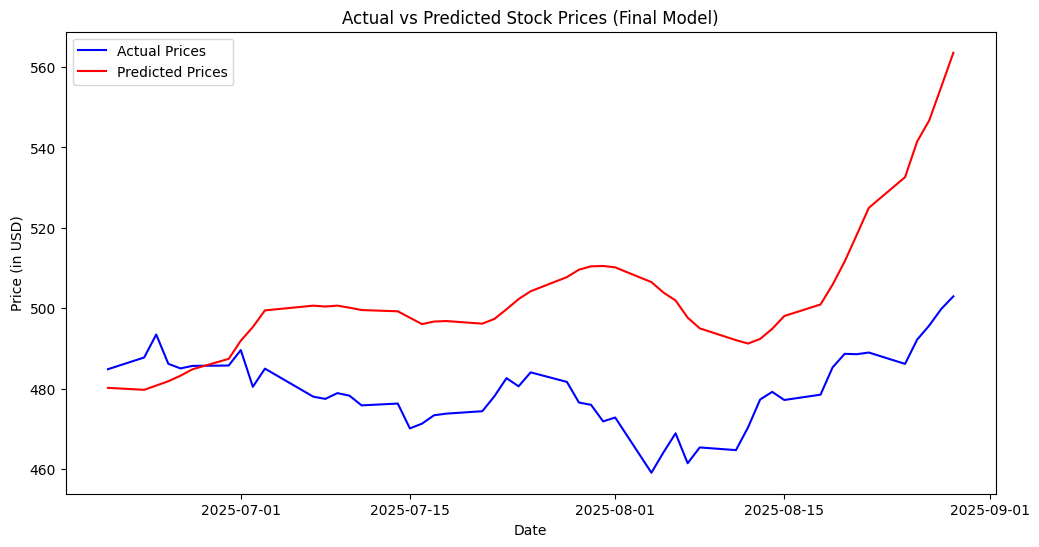

<Figure size 640x480 with 0 Axes>

In [101]:
# Plot the final actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred_final, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (Final Model)')
plt.xlabel('Date')
plt.ylabel('Price (in USD)')
plt.legend()
plt.show()
plt.savefig("prediction_plot.png", dpi=300, bbox_inches="tight")


In [97]:
# Assuming we have the most recent data, let's predict the next day's stock price
future_data = data.tail(1)[['MA50', 'MA200']]  # Get the latest data
future_pred = grid_search.predict(future_data)

print(f"Predicted price for the next day: {future_pred[0]}")


Predicted price for the next day: [563.56870772]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
